# Monologic Voice

*January 19*

Three sections, replicating the same code for different data:
- all annotated sentences, regardless of opinion category
- only dissenting sentences
- only majority sentences


**Continued issues:**
- ~vectorizer is removing "I"; since "we" is most important feature, probably want to include "I"~
    - ~Any way to do this without creating new vectorizer from ground up (i.e. not using scikitlearn)?~
- accuracy (f1) is still relatively low for all sentences; really bad for dissenting sentences; decent for majority only
- word "court" seems to be confusing classiffier --> "Court" usually refers to US Supreme Court and typically indicates monologic--but "court" (lowercase) usually refers to other courts (not monologic)

In [20]:
import json
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import linear_model
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, GroupKFold
from sklearn.metrics import f1_score, average_precision_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import metrics
import nltk

In [2]:
file_name = "Data/monologic_annotations.json"

In [3]:
annotations = []
for line in open(file_name, 'r'):
    annotations.append(json.loads(line))
annotations_df = pd.DataFrame(annotations)
print(annotations_df.shape)
annotations_df.head(10)

(5982, 20)


,Unnamed: 0,Unnamed: 0.1,opinion_num,categority,author,case,text,sent_index,length,sent_location,prediction,prob_0,prob_1,_input_hash,_task_hash,label,_session_id,_view_id,answer,_merge
0,377463,377463,3642,dissenting,Justice Thomas,Reyes Mata v. Lynch,And they should\napply the ordinary rule that ...,30,34,0.882353,1,0.485290,0.514710,-1275484070,-689703587,MONOLOGIC,None,classification,reject,NaN
1,953867,953867,8962,majority,Justice Thomas,"Professional Real Estate Investors, Inc. v. Co...",The sham exception so construed would undermin...,137,218,0.628440,1,0.337235,0.662765,1819283346,1898932554,MONOLOGIC,None,classification,reject,NaN
2,277192,277192,2673,majority,Justice Burton,Order of United Commercial Travelers of Americ...,The prohibition limiting the time for suing on...,144,295,0.488136,1,0.282745,0.717255,1411906233,-909861218,MONOLOGIC,None,classification,reject,NaN
3,217250,217250,2124,dissenting,Justice Stewart,Simpson v. Union Oil Co. of Cal.,"To answer that question, the Court examined th...",21,56,0.375000,1,0.335661,0.664339,-1857841816,-1068803877,MONOLOGIC,None,classification,reject,NaN
4,1417865,1417865,13283,second_dissenting,Justice Ginsburg,"DIRECTV, Inc. v. Imburgia",is not a sufficient reason\nto hold that arbit...,122,174,0.701149,1,0.188354,0.811646,91625303,2113589606,MONOLOGIC,None,classification,reject,NaN
5,1494023,1494023,14062,majority,Justice Marshall,Dunn v. United States,But that is not the inference the Department o...,101,134,0.753731,1,0.378012,0.621988,-2010364810,895034902,MONOLOGIC,None,classification,reject,NaN
6,1628870,1628870,15362,majority,Justice Kennedy,Colonial American Life Ins. Co. v. Commissioner,The ceding commissions thus are not administra...,47,141,0.333333,1,0.281314,0.718686,-649556952,1616257439,MONOLOGIC,None,classification,reject,NaN
7,35313,35313,347,second_dissenting,Justice White,Milliken v. Bradley,Negro students are not only entitled to neutra...,346,550,0.629091,1,0.332815,0.667185,377348157,61246947,MONOLOGIC,None,classification,reject,NaN
8,1449928,1449928,13625,majority,Justice Powell,Pennsylvania v. Ritchie,It ruled that the constitutional infirmity in ...,39,192,0.203125,1,0.283058,0.716942,1825211886,-1145212941,MONOLOGIC,None,classification,reject,NaN
9,1220653,1220653,11443,majority,Justice Alito,"B&B Hardware, Inc. v. Hargis Industries, Inc.",Concluding that “the most\ncritical factors in...,90,303,0.297030,1,0.257384,0.742616,1861699898,1313311744,MONOLOGIC,None,classification,reject,NaN


In [4]:
annotations_df["label_num"] = annotations_df["answer"].map({'accept': 1, 'reject': 0, 'ignore': 0})
print(annotations_df.answer.value_counts())

reject    4419
accept    1562
ignore       1
Name: answer, dtype: int64


In [5]:
print(annotations_df.categority.value_counts())

majority             3423
dissenting           1528
concurring            511
second_dissenting     401
per_curiam            119
Name: categority, dtype: int64


In [6]:
grouped = annotations_df.groupby(["answer"])
grouped.prob_1.mean()

answer
accept    0.774431
ignore    0.679398
reject    0.706140
Name: prob_1, dtype: float64

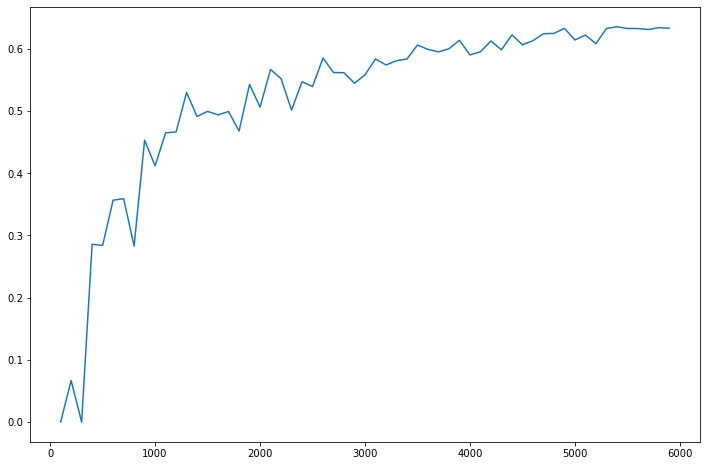

In [92]:
stop_words=frozenset(['the', 'be', 'to', 'of', 'and', 'a', 'in', 'that', 'have', 'it', 'for', 'not', 'on', 'with', 'as', 'do', 'at', 'this', 'but', 'by', 'from'])

# Set up the vectorizer

vectorizer = TfidfVectorizer(
    encoding='utf-8',
    min_df=2,
    max_df=.90,
    #stop_words=stop_words,
    binary=False,
    #tokenizer=nltk.word_tokenize,
    norm='l2',
    use_idf=False 
)

vectorizer.fit(annotations_df.text)

# Classification
lr = LogisticRegression()
x_values = []
y_values = []
scores_l = []

sample_sizes = range(100, len(annotations_df.label_num), 100)

for i in sample_sizes:
    sample_df = annotations_df.sample(n=i)
    y_opinions = sample_df["label_num"]
    X_opinions = vectorizer.transform(sample_df.text)
    # Cross validation
    scores = cross_validate(lr, X_opinions, y_opinions, cv=5, scoring=['accuracy', 'f1', 'f1_macro', 'f1_micro'])
    scores_l.append(scores)
    x = len(y_opinions)
    x_values.append(x)
    y = np.mean(scores.get("test_f1"))
    y_values.append(y)

fig, ax = plt.subplots(figsize=(12,8))
plt.plot(x_values, y_values);

In [93]:
# Total documents
y_opinions = annotations_df["label_num"]
X_opinions = vectorizer.fit_transform(annotations_df.text)

In [94]:
import numpy as np
from sklearn.dummy import DummyClassifier
X = X_opinions
y = y_opinions
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X, y)

dummy_clf.predict(X)

dummy_clf.score(X, y)

0.7388833166165162

In [95]:
# Baseline scores
baseline_accuracy = sum(y_opinions)/len(y_opinions)
baseline_precision = baseline_accuracy
baseline_recall = 1.0
baseline_f1 = 2*baseline_precision*baseline_recall/(baseline_precision+baseline_recall)
print("Baseline accuracy:", 1-round(baseline_accuracy, 3))
print("Baseline F1:", round(baseline_f1, 3))

Baseline accuracy: 0.739
Baseline F1: 0.414


In [109]:
lr = LogisticRegression()
scores = cross_validate(lr, X_opinions, y_opinions, cv=5, scoring=['accuracy', 'f1', 'f1_macro', 'f1_micro'])
print(np.mean(scores.get("test_f1")))
print(np.mean(scores.get("test_accuracy")))

0.6387277516761762
0.850217377334082


In [110]:
X_train, X_test, y_train, y_test = train_test_split(X_opinions, y_opinions, test_size=0.30)

In [111]:
lr.fit(X_train, y_train)

LogisticRegression()

In [112]:
y_predict = lr.predict(X_test)

In [113]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.83      0.97      0.90      1300
           1       0.88      0.47      0.61       495

    accuracy                           0.84      1795
   macro avg       0.85      0.72      0.75      1795
weighted avg       0.84      0.84      0.82      1795



In [101]:
from sklearn.metrics import precision_recall_fscore_support

In [102]:
precision_recall_fscore_support(y_test, y_predict, average="weighted")

(0.8476855366643131, 0.8385155466399198, 0.8188971715202581, None)

# Feature Importance

In [12]:
# Fit the model
lr.fit(X_opinions, y_opinions)

LogisticRegression()

In [13]:
# Coefficient importance
coef_dict = {}
for coef, feat in zip(lr.coef_[0],vectorizer.get_feature_names()):
    coef_dict[feat] = coef

print(coef_dict.get("we"))
print(coef_dict.get("i"))

15.075645187678354
11.665326306450908


In [14]:
top_feat_dict = {k:v for (k,v) in coef_dict.items() if v > 1}
dict_df = pd.DataFrame.from_dict(top_feat_dict, orient='index')
dict_df['feature'] = dict_df.index
dict_df.sort_values(by=[0], ascending=False).head(20)

,0,feature
we,15.075645,we
i,11.665326,i
our,7.724458,our
us,4.845297,us
my,4.609844,my
me,3.912168,me
court,3.496801,court
majority,1.853874,majority
conclude,1.640598,conclude
view,1.587438,view


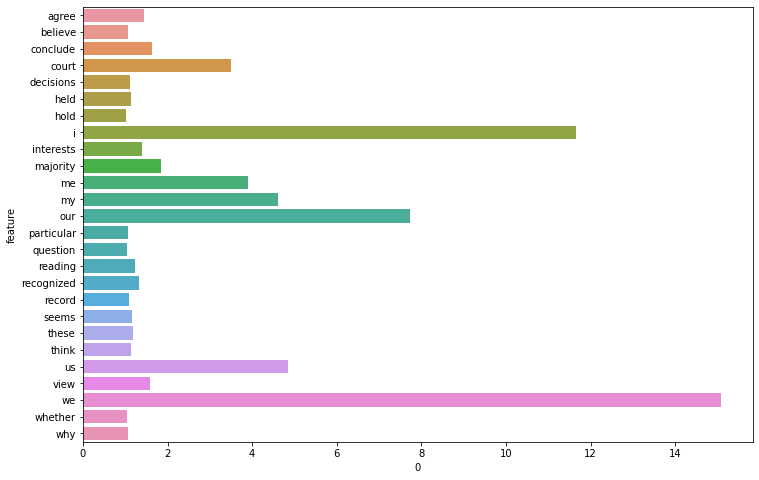

In [15]:
# Plot
import seaborn as sns
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.barplot(x=0, y="feature", data=dict_df)

## Permutation Importance
**NOTE**: This permutation dictionary was created with the previous vectorizer settings (use-idf == True and no stopwords); permutation will be run again once other issues are fixed

In [16]:
import pickle
# Load permutation dictionary
perm_dict = pickle.load(open("Data/mon_perm_dict.p", "rb" ))
perm_dict_df = pd.DataFrame.from_dict(perm_dict, orient='index')
perm_dict_df['feature'] = perm_dict_df.index
smaller_perm_df = perm_dict_df.sort_values(by=[0], ascending=False).head(20)
perm_dict_df.sort_values(by=[0], ascending=False).head(20)

,0,feature
we,0.109580,we
our,0.009330,our
my,0.004702,my
dissent,0.003727,dissent
court,0.002476,court
me,0.001801,me
think,0.001651,think
respectfully,0.001576,respectfully
conclude,0.001501,conclude
agree,0.001376,agree


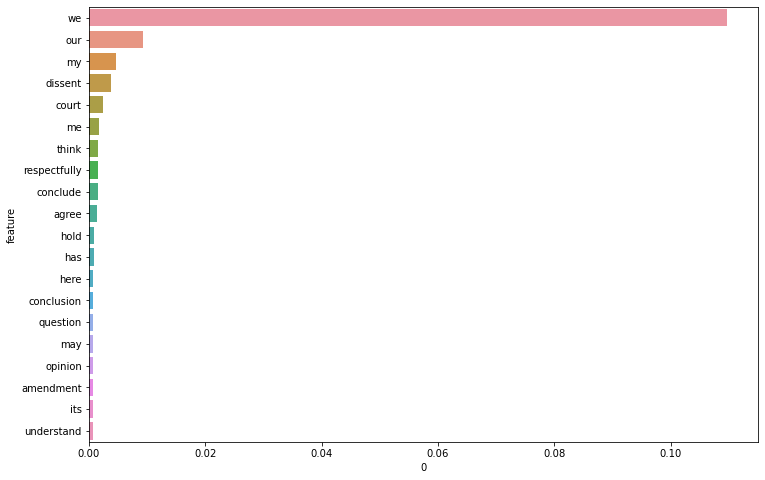

In [17]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.barplot(x=0, y="feature", data=smaller_perm_df)

# Probability and Errors

In [18]:
probability_scores = lr.predict_proba(X_opinions)[:,1]
# Still need to show which sentences are highest probability of 1

In [19]:
y_best = lr.predict(X_opinions)
# Need to add cross validation
def pull_errors(labels, gold_labels, corpus, n=3):
    labeled_opinions = pd.DataFrame(
        {
            'gold':gold_labels,
            'computed': labels,
            'text':corpus
        }
    )
    errors = labeled_opinions.loc[labeled_opinions.gold != labeled_opinions.computed]
    with pd.option_context('display.max_colwidth', None):
        display(errors.sample(n))

pull_errors(y_best, y_opinions, annotations_df.text, n=10)

,gold,computed,text
5630,0,1,"It may be that the relevant data base is too small to permit any meaningful statistical analysis, but we leave the Court of Appeals to decide in the first instance, on the basis of the record and the principles announced today, whether this case can be resolved without further proceedings in the District Court."
3091,0,1,We agree with the Rouseys that IRAs are similar to the plans specified in the statute.
4359,1,0,"Indeed, this Court observed in Wissner:\n""Possession of government insurance, payable to the relative of his choice, might well directly enhance the morale of the serviceman."
2182,1,0,The Court's finding is grounded on the assumption that the collective-bargaining agreement somehow entitles the employer to rely on the union to bring any wrongful discharge to its attention within the context of the grievance machinery.
1962,1,0,"If these contentions are correct, it is unnecessary, of course, to reach any of the issues concerning remedies that so occupied the attention of the Court of Appeals."
323,1,0,"* * *\nWhile some might complain that our system of dual sovereignty is not a model of administrative convenience, see, e. g., post, at 785-786 (Breyer, J., dissenting), that is not its purpose."
3666,0,1,"Many other federal statutes preempt state law in this\nway, leaving the context-specific scope of preemption to\n\n——————\n 3 Because the statute alone resolves this dispute, we need not consider\n\nwhether Chevron deference attaches to OPM’s 2015 rule."
498,0,1,"Our appointed Special Master agreed, recommending that we find that Colorado had unlawfully depleted the river in violation of Art."
760,1,0,"I would hold that 'inland waters' should be measured in Louisiana, and in any other State with similar coastal characteristics, by the standard urged by Louisiana—the Coast Guard line established years ago, under the authority of an 1895 Act of Congress, to mark off the boundaries of the States' 'inland waters.'"
4244,1,0,"II\nThe basic question before us is whether there has been a ""continuing failure or neglect to obey"" an FTC order within the meaning of 15 U.S. C. §§ 21 (l) and 45 (l)."


Some of the errors look like Court/court errors (or general confusion over which court is referenced), but others also look like sentences I was on the fence about/mislabeled. Additionally, there might be issues with poor tokenization (like "\n\n----\n") which actually says nothing about the content of the sentence. 

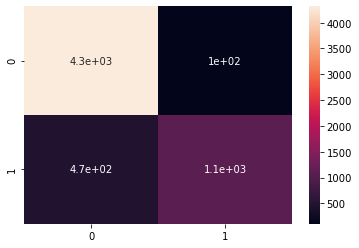

In [20]:
# Confusion Matrix
confusion_m = metrics.confusion_matrix(y_opinions, y_best)
sns.heatmap(confusion_m, annot=True);

***
# Monologic Voice in Dissent

In [21]:
file_name = "Annotations/monologic_annotations.json"
annotations = []
for line in open(file_name, 'r'):
    annotations.append(json.loads(line))
annotations_df = pd.DataFrame(annotations)
annotations_df["label_num"] = annotations_df["answer"].map({'accept': 1, 'reject': 0, 'ignore': 0})
dissenting_df = annotations_df[annotations_df.categority == "dissenting"]

In [22]:
print("Sentence distribution:")
print(dissenting_df.answer.value_counts())
print("Number of each category:")
print(dissenting_df.categority.value_counts())

Sentence distribution:
reject    1075
accept     452
ignore       1
Name: answer, dtype: int64
Number of each category:
dissenting    1528
Name: categority, dtype: int64


/Users/rosamondthalken/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


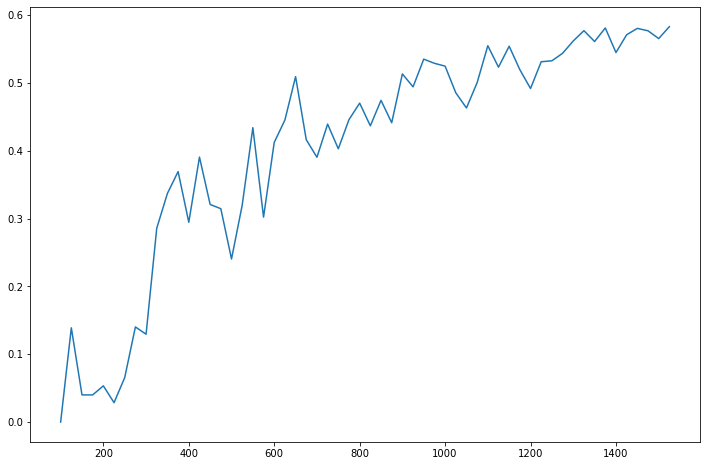

In [23]:
sample_sizes = range(100, len(dissenting_df.label_num), 25)

stop_words=frozenset(['the', 'be', 'to', 'of', 'and', 'a', 'in', 'that', 'have', 'it', 'for', 'not', 'on', 'with', 'as', 'do', 'at', 'this', 'but', 'by', 'from'])

diss_vectorizer = TfidfVectorizer(
    encoding='utf-8',
    min_df=2, 
    stop_words=stop_words,
    binary=False,
    tokenizer=nltk.word_tokenize,
    norm='l2',
    use_idf=False 
)

diss_vectorizer.fit(dissenting_df.text)

# Classification
lr = LogisticRegression()
x_values = []
y_values = []
scores_l = []

for i in sample_sizes:
    sample_df = dissenting_df.sample(n=i)
    y_opinions = sample_df["label_num"]
    X_opinions = diss_vectorizer.transform(sample_df.text)
    # Cross validation
    scores = cross_validate(lr, X_opinions, y_opinions, cv=5, scoring=['accuracy', 'f1', 'f1_macro', 'f1_micro'])
    scores_l.append(scores)
    x = len(y_opinions)
    x_values.append(x)
    y = np.mean(scores.get("test_f1"))
    y_values.append(y)
    
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(x_values, y_values);

In [24]:
y_opinions = dissenting_df["label_num"]
X_opinions = diss_vectorizer.fit_transform(dissenting_df.text)
# Baseline scores
baseline_accuracy = sum(y_opinions)/len(y_opinions)
baseline_precision = baseline_accuracy
baseline_recall = 1.0
baseline_f1 = 2*baseline_precision*baseline_recall/(baseline_precision+baseline_recall)
print("Baseline accuracy:", round(baseline_accuracy, 3))
print("Baseline F1:", round(baseline_f1, 3))

Baseline accuracy: 0.296
Baseline F1: 0.457


In [25]:
lr = LogisticRegression()
scores = cross_validate(lr, X_opinions, y_opinions, cv=5, scoring=['accuracy', 'f1', 'f1_macro', 'f1_micro'])
print(np.mean(scores.get("test_f1")))
print(np.mean(scores.get("test_accuracy")))

0.5718238229441023
0.81739847851709


In [26]:
# Coefficient importance
# Fit the model
lr.fit(X_opinions, y_opinions)
coef_dict = {}
for coef, feat in zip(lr.coef_[0],diss_vectorizer.get_feature_names()):
    coef_dict[feat] = coef

print(coef_dict.get("we"))
print(coef_dict.get("i"))

6.441116521566521
8.017568601189414


In [32]:
# reduced to just top features--for dissent might need to change 1
top_feat_dict = {k:v for (k,v) in coef_dict.items() if v > .8}
keys = top_feat_dict.keys()
values = top_feat_dict.values()

dict_df = pd.DataFrame.from_dict(top_feat_dict, orient='index')
dict_df['feature'] = dict_df.index
dict_df.sort_values(by=[0], ascending=False).head(20)

,0,feature
i,8.017569,i
we,6.441117,we
our,4.050388,our
court,2.710589,court
my,2.681668,my
me,2.005612,me
us,1.558349,us
's,1.135451,'s
view,1.082889,view
majority,1.045687,majority


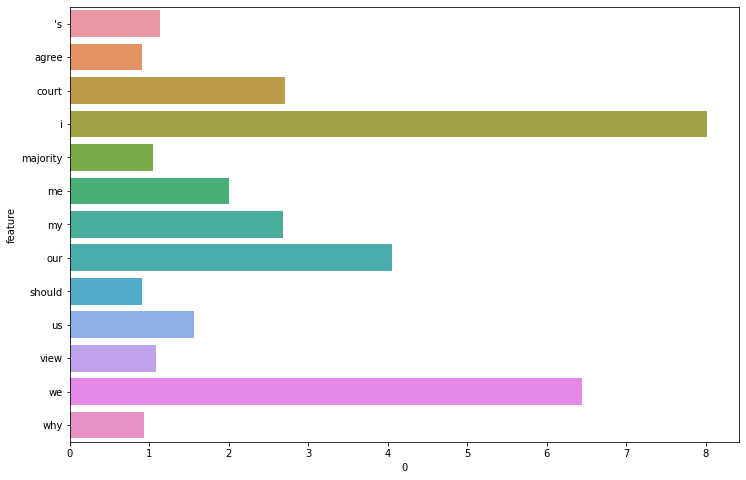

In [33]:
# Plot
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.barplot(x=0, y="feature", data=dict_df)

In [34]:
y_best = lr.predict(X_opinions)
pull_errors(y_best, y_opinions, dissenting_df.text, n=10)

,gold,computed,text
2533,1,0,In prior cases the Court has been careful to distinguish between these two issues.
2729,1,0,"Its theory, as I have described, is that a juror who will always impose the death penalty for capital murder is one who ""will fail in good faith to consider the evidence of aggravating and mitigating circumstances as the instructions require him to do, "" ante, at 729 (emphasis added)."
4363,1,0,"In those circumstances, as the majority suggests,\nthe agency may be able to support an expert’s testimony in\nways other than by providing underlying data, such as by\noffering a fulsome description of the data and methodology\non which the expert relies."
3981,1,0,"This Court long ago abandoned the tidal test in favor of the navigability test for defining federal admiralty jurisdiction, describing the ebb and flow test as ""purely artificial and arbitrary as well as unjust."""
5934,1,0,This is what happens when the Court departs from the text of a nationwide statute to reach a result in one particular State.
1305,1,0,"This does not seem to me to be the way to undertake Fourth Amendment analysis, especially in an area with which the Court is relatively unfamiliar."
3602,1,0,"We have only authorized exemptions from the Sherman Act for businesses regulated by federal law when ""that exemption was necessary in order to make the regulatory Act work `and even then only to the minimum extent necessary.'"
3389,1,0,"Indeed, the rewriting here is so complete that, no matter how deeply one admires and venerates ""pre-Code law,"" it is impossible to interpret § 506(d) in a manner that entirely preserves it and the Court itself, for all its protestation of fealty, does not do so."
3170,1,0,"In my own State since its foundation the right has been conceded."""
3623,1,0,Are we to assume that the stevedore agreed to an unlimited liability for indemnity without regard to the comparative or qualitative proportions of negligence as between its employees and the employees of the shipowner?


***
# Just Majority

In [35]:
file_name = "Annotations/monologic_annotations.json"
annotations = []
for line in open(file_name, 'r'):
    annotations.append(json.loads(line))
annotations_df = pd.DataFrame(annotations)
annotations_df["label_num"] = annotations_df["answer"].map({'accept': 1, 'reject': 0, 'ignore': 0})
majority_df = annotations_df[annotations_df.categority == "majority"]

/Users/rosamondthalken/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


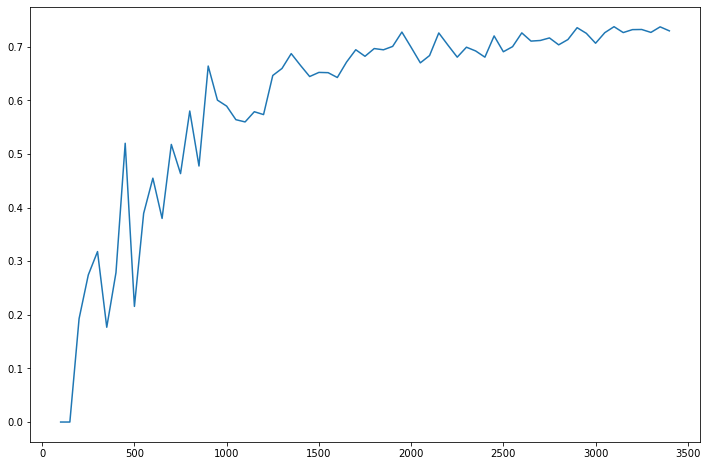

In [36]:
sample_sizes = range(100, len(majority_df.label_num), 50)

stop_words=frozenset(['the', 'be', 'to', 'of', 'and', 'a', 'in', 'that', 'have', 'it', 'for', 'not', 'on', 'with', 'as', 'do', 'at', 'this', 'but', 'by', 'from'])

maj_vectorizer = TfidfVectorizer(
    encoding='utf-8',
    min_df=2, 
    stop_words=stop_words,
    binary=False,
    tokenizer=nltk.word_tokenize,
    norm='l2',
    use_idf=False 
)

maj_vectorizer.fit(majority_df.text)

# Classification
lr = LogisticRegression()
x_values = []
y_values = []
scores_l = []

for i in sample_sizes:
    sample_df = majority_df.sample(n=i)
    y_opinions = sample_df["label_num"]
    X_opinions = maj_vectorizer.transform(sample_df.text)
    # Cross validation
    scores = cross_validate(lr, X_opinions, y_opinions, cv=5, scoring=['accuracy', 'f1', 'f1_macro', 'f1_micro'])
    scores_l.append(scores)
    x = len(y_opinions)
    x_values.append(x)
    y = np.mean(scores.get("test_f1"))
    y_values.append(y)
    
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(x_values, y_values);

In [37]:
y_opinions = majority_df["label_num"]
X_opinions = maj_vectorizer.fit_transform(majority_df.text)
# Baseline scores
baseline_accuracy = sum(y_opinions)/len(y_opinions)
baseline_precision = baseline_accuracy
baseline_recall = 1.0
baseline_f1 = 2*baseline_precision*baseline_recall/(baseline_precision+baseline_recall)
print("Baseline accuracy:", round(baseline_accuracy, 3))
print("Baseline F1:", round(baseline_f1, 3))

Baseline accuracy: 0.232
Baseline F1: 0.377


In [15]:
lr = LogisticRegression()
scores = cross_validate(lr, X_opinions, y_opinions, cv=5, scoring=['accuracy', 'f1', 'f1_macro', 'f1_micro'])
print(np.mean(scores.get("test_f1")))
print(np.mean(scores.get("test_accuracy")))
#print(np.mean(scores.get("test_recall")))
# Note: before changing tokenization this f1 was 75; after change it's almost 73

0.7434840390822242
0.885491320273929


TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

In [41]:
# Coefficient importance
# Fit the model
lr.fit(X_opinions, y_opinions)
coef_dict = {}
for coef, feat in zip(lr.coef_[0],maj_vectorizer.get_feature_names()):
    coef_dict[feat] = coef

In [42]:
top_feat_dict = {k:v for (k,v) in coef_dict.items() if v > .8}
keys = top_feat_dict.keys()
values = top_feat_dict.values()

dict_df = pd.DataFrame.from_dict(top_feat_dict, orient='index')
dict_df['feature'] = dict_df.index
dict_df.sort_values(by=[0], ascending=False).head(20)

,0,feature
we,14.642205,we
our,6.839304,our
i,4.843197,i
us,3.638326,us
court,2.115043,court
question,1.387661,question
conclude,1.380724,conclude
held,1.249881,held
hold,1.108396,hold
cases,1.029668,cases


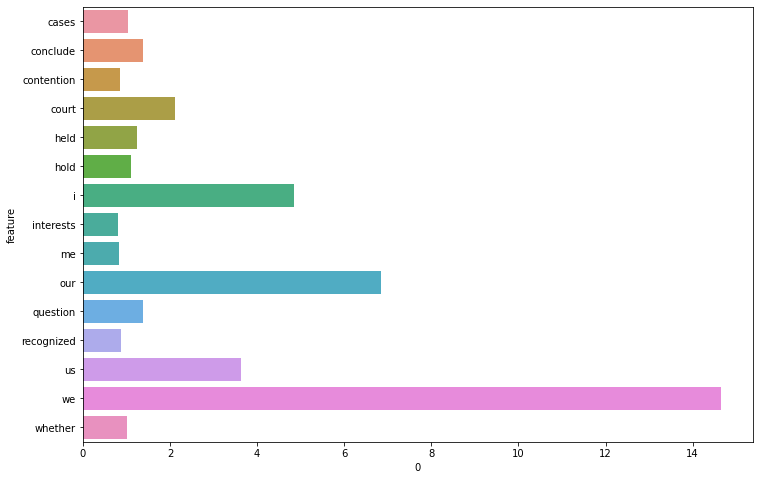

In [43]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.barplot(x=0, y="feature", data=dict_df)

In [44]:
y_best = lr.predict(X_opinions)
pull_errors(y_best, y_opinions, majority_df.text, n=10)

,gold,computed,text
5921,1,0,Their father is dead; they live with me.
844,1,0,"II\nWe think that appellees' showing of numerical deviations from population equality among the Senate and *741 House districts in this case failed to make out a prima facie violation of the Equal Protection Clause of the Fourteenth Amendment, whether those deviations are considered alone or in combination with the additional fact that another plan could be conceived with lower deviations among the State's legislative districts."
2655,1,0,"The various doctrines of ""standing,""[5]*504 ""ripeness,""[6] and ""mootness,""[7] which this Court has evolved with particular, though not exclusive, reference to such cases are but several manifestationseach having its own ""varied application""[8]of the primary conception that federal judicial power is to be exercised to strike down legislation, whether state or federal, only at the instance of one who is himself immediately harmed, or immediately threatened with harm, by the challenged action."
3641,1,0,"[4]\n\nIII\nThe Court does not reach the question whether a union may be held liable under Title VII for ""mere passivity"" in the face of discrimination by the employer, because it agrees with the courts below that the record shows more than mere passivity on the part of the Unions."
5330,1,0,"The MCA does not purport to be a formal suspension of the writ; and the Government, in its submissions to us, has not argued that it is."
4185,0,1,It is in light of this legislative silence that we must determine whether § 4B is tolled by Commission proceedings.
1897,1,0,"At this time it is necessary only to avoid imposing, from the level of this Court, arbitrary limitations on the exercise of this traditional discretion specifically explicated in § 706 (g)."
4277,1,0,"In this case, our inquiry under Agostini's purpose and effect test is a narrow one."
5194,1,0,"The treaty language at issue in each of the four cases is\nsimilar, though not identical, to the language before us."
2587,1,0,"In United States v. Calandra, 414 U. S., at 348, we said that the exclusionary rule ""is a judicially created remedy designed to safeguard Fourth Amendment rights generally through its deterrent effect, rather than a personal constitutional right of the party aggrieved."""
